In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp #se hace la instalación en pip, igual que neural_tangent
from jax.config import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)
from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from functools import partial
from jax import random, grad, jit, vmap, jvp
import numpy as np
import igl

from torch.utils import data #se instala pytorch para esto
from scipy.sparse.linalg import spsolve
rng_key = random.PRNGKey(0)
import time
import meshio
#
#Paquetes adicionales del código Delta-PINN
import pyvista as pv #requiere un ambiente de pyhton sobre python 3.7
import tetgen #se debe instalar con pip en conda
import sys
sys.path.append("utils")
from Mesh_tetra import Mesh
#
##Paquete adicionales dell código WARPINN
import os
from timeit import default_timer as timer

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mesh importation and tetrahedralization

In [2]:
data_dense = pv.PolyData('DENSE/S2_triangles.stl')

tet = tetgen.TetGen(data_dense)
tet.make_manifold()
tet.tetrahedralize(minratio = 1.0, mindihedral = 30)

heart_grid = tet.grid

# create Mesh object
connectivity_dense = heart_grid.cells_dict[10] # extract tetrahedra
points_dense       = heart_grid.points
centroids_dense    = points_dense[connectivity_dense].mean(1)

m = Mesh(verts = points_dense, connectivity = connectivity_dense)

Fibers are imported and the first diffusion tensor direction are selected.

In [3]:
invivo_fiber = np.genfromtxt('DENSE/S2/S2_invivo.Fiber')
first_eigs_invivo = invivo_fiber[:, :3]

Something worth noting is that fibers are imported already normalized. On the other hand, points are shown.

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


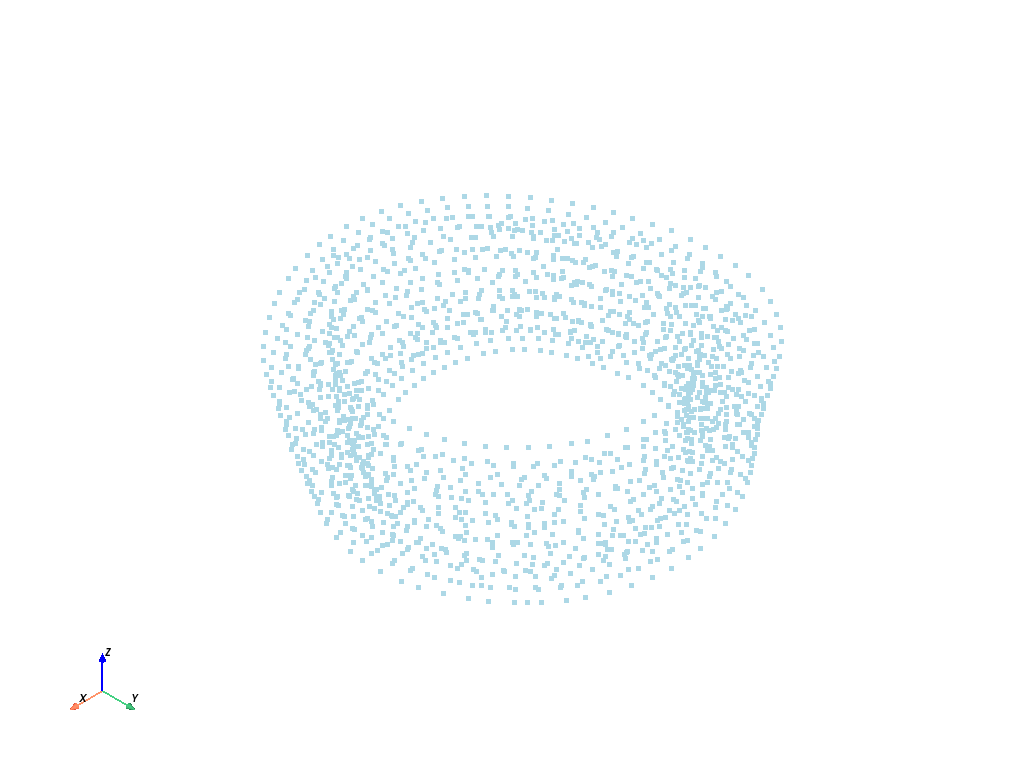

In [4]:
pv.PolyData(points_dense).plot('data')

Quadrature points are imported.

In [5]:
interpolation_points = np.genfromtxt('Quadrature/quadrature_points.csv', delimiter = " ")
interpolation_points = jnp.array(interpolation_points)

### Fibers mapping inside the mesh.

In [6]:
mid_mesh = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
mid_mesh['data'] = points_dense

mesh_points = pv.PolyData(np.array(interpolation_points))
result = mesh_points.sample(mid_mesh)

mesh_points['error'] = np.linalg.norm(result['data'] - interpolation_points, axis = 1)

It is checked which quadrature points are inside the mesh.

In [7]:
error = np.linalg.norm(result['data'] - interpolation_points, axis = 1)
tol = 1e-6
index_inside_points = np.squeeze(np.argwhere(error < tol))

if index_inside_points.shape[0] == interpolation_points.shape[0]:
    print("Every quadrature point is inside the mesh.")
else:
    print("Some points need to be extracted.")

Every quadrature point is inside the mesh.


As all points are inside the mesh, the arrays to show fibers in Paraview are created.

In [8]:
np.savetxt('Obtain_Fiber_output/Fiber_to_plot/fibers_invivo.csv', np.concatenate((interpolation_points, first_eigs_invivo), axis = 1))

In [9]:
def normalize_fiber(fiber):
    return (1/jnp.linalg.norm(fiber))*fiber

### Interpolated Fibers with pyvista to the mesh element centroids.

In [10]:
first_fib_mesh = pv.PolyData(np.array(centroids_dense))

mesh_points_first_fib = pv.PolyData(np.array(interpolation_points))
mesh_points_first_fib['first_fibers'] = first_eigs_invivo

result_first_fib = first_fib_mesh.interpolate(mesh_points_first_fib)
interpolation_first_fibs = result_first_fib['first_fibers']
interpolation_first_fibs = jnp.array(interpolation_first_fibs)
interpolation_first_fibs = vmap(normalize_fiber)(interpolation_first_fibs)

np.savetxt('Obtain_Fiber_output/interpolated_first_fibers_centroids.csv', interpolation_first_fibs)
np.savetxt('Obtain_Fiber_output/Fiber_to_plot/interpolated_first_fibers_centroids_to_plot.csv', np.concatenate((centroids_dense, interpolation_first_fibs), axis = 1))

In [11]:
print(centroids_dense.shape, interpolation_first_fibs.shape)

(6433, 3) (6433, 3)


$\textbf{l}$ direction is calculated for further projections.

In [12]:
l_direction = []
for i in range(centroids_dense.shape[0]):
    l_direction.append([0, 0, 1])
l_direction = jnp.array(l_direction)

$\textbf{r}$ direction is calculated as the distance from the point (0,0,0), considering $\hat{z}$ coordinate as 0. Then $\textbf{c}$ direction is simply $\textbf{c} = \textbf{l}\times \textbf{r}$.

In [13]:
r_direction = vmap(normalize_fiber)(centroids_dense[:, 0:2])
r_direction = jnp.concatenate((r_direction, jnp.array([jnp.zeros_like(r_direction[:, 0])]).T), axis = 1)
c_direction = vmap(normalize_fiber)(np.cross(l_direction, r_direction))

np.savetxt('Obtain_Fiber_output/Fiber_to_plot/c_dir_to_plot.csv', np.concatenate((centroids_dense, c_direction), axis = 1))
np.savetxt('Obtain_Fiber_output/Fiber_to_plot/r_dir_to_plot.csv', np.concatenate((centroids_dense, r_direction), axis = 1))
np.savetxt('Obtain_Fiber_output/Fiber_to_plot/l_dir_to_plot.csv', np.concatenate((centroids_dense, l_direction), axis = 1))

Lastly, outer product fiber matrices are computed.

In [14]:
fxf_det = lambda x: jnp.linalg.det(x)
fxf_original_fn = lambda x: jnp.outer(x, x)
fxf_first = vmap(fxf_original_fn)(first_eigs_invivo)
interpolation_rxr = jnp.array(vmap(fxf_original_fn)(r_direction)).reshape((-1, 9))
interpolation_cxc = jnp.array(vmap(fxf_original_fn)(c_direction)).reshape((-1, 9))
interpolation_lxl = jnp.array(vmap(fxf_original_fn)(l_direction)).reshape((-1, 9))

fxf_mesh = pv.PolyData(np.array(centroids_dense))
mesh_points_fxf = pv.PolyData(np.array(interpolation_points))
mesh_points_fxf['fxf'] = fxf_first.reshape((-1, 9))
result_fxf = fxf_mesh.interpolate(mesh_points_fxf)
interpolation_fxf = result_fxf['fxf']
interpolation_fxf = jnp.array(interpolation_fxf)
np.savetxt('Obtain_Fiber_output/fxf_interpolated.csv', interpolation_fxf)
np.savetxt('Obtain_Fiber_output/lxl_interpolated.csv', interpolation_lxl)
np.savetxt('Obtain_Fiber_output/rxr_interpolated.csv', interpolation_rxr)
np.savetxt('Obtain_Fiber_output/cxc_interpolated.csv', interpolation_cxc)

To check if the interpolation is workinf properly, the fibers are recovered from fxf considering the third eigenvalue as positive.

In [15]:
def rec_f(fxf):
    f_3 = jnp.sqrt(fxf[-1])
    f_1 = fxf[2]/f_3
    f_2 = fxf[5]/f_3
    f = jnp.array([f_1, f_2, f_3])
    return f

recovered_fibers = vmap(rec_f)(interpolation_fxf)
rec_fib_norm = vmap(normalize_fiber)(recovered_fibers)

np.savetxt('Obtain_Fiber_output/Fiber_to_plot/recovered_fibers_centroids_to_plot.csv', np.concatenate((centroids_dense, recovered_fibers), axis = 1))